In [1]:
import requests
import pandas as pd

# Importing HPI data and Vaccine data
hpi_data = requests.get('https://api.healthyplacesindex.org/api/hpi?geography=tracts&year=2020&indicator=voting&format=json&key=f07f86d6-58b5-40e3-a17f-333b92ccc57d').json()
vaccine_data = requests.get('https://data.sandiegocounty.gov/resource/nrkb-eanb.json').json()

# hpi_data
# vaccine_data

# Converting data (python dictionary) to a pandas dataframe
# Resetting titles (variables) the dataframe versions
hpi_data = pd.DataFrame(hpi_data)
vaccine_data = pd.DataFrame(vaccine_data)


# hpi_data.head(1)
# vaccine_data.head(5)
# df_hpi_data

In [161]:
# filtered = vaccine_data[vaccine_data['objectid'] == '51876']
# filtered = vaccine_data[vaccine_data['census_tract'] == '170.55']
vaccine_data[vaccine_data['census_tract'] == '170.55']



# filtered

,the_geom,objectid,census_tract,count_vaccinated,gis_hpi_quartile_sd,doses_through,update_date,shape_length,shape_area,globalid,vaccination_percentage_all,censuspop_all,notes,censuspop_16plus,vaccination_percentage,censuspop_5plus,vaccination_percentage_5plus,censuspop_12plus,vaccination_percentage_12plus
396,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",51946,170.55,4403,4,2022-07-25T08:00:00.000Z,2022-07-27T08:00:00.000Z,7844.262960753492,2929824.80743924,{2A189B27-E03D-4353-B5A0-9EEE452C3AFD},77.90162774,5652,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
hpi_data.head(1)

,geoid,name,population,value,percentile,numerator,denominator
0,06013370000,3700,2850,0.848177,0.726187,1805.769339,2129


In [2]:
#Import from Google Drive - Master HPI Data. Recieved this file directly from the HPI agency. 
# Will use this file as an intermidiary- common key is needed from this file to join HPI data and Vaccine data

import pandas as pd

url='https://drive.google.com/file/d/1-O5aXOkgAaQUxMjZ5EXu9y6kHxmjsyp2/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
master_hpi = pd.read_csv(path)

master_hpi = pd.DataFrame(master_hpi)

#Cleaning/Filtering mster HPI data. Preparing to join. 
# san_diego_hpi = master_hpi[master_hpi['county']=='San Diego']
san_diego_hpi = master_hpi[master_hpi['county']=='San Diego']


san_diego_hpi['NAME'] = [x.split(',')[-0] for x in san_diego_hpi['NAME']]

san_diego_hpi['NAME'] = [x.split('Tract ')[-1] for x in san_diego_hpi['NAME']]

san_diego_hpi.head(3)
# len(san_diego_hpi)

C:\Users\krist\AppData\Local\Temp\ipykernel_596\1041977483.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_diego_hpi['NAME'] = [x.split(',')[-0] for x in san_diego_hpi['NAME']]
C:\Users\krist\AppData\Local\Temp\ipykernel_596\1041977483.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_diego_hpi['NAME'] = [x.split('Tract ')[-1] for x in san_diego_hpi['NAME']]


,GEO_ID,NAME,county,pop,pctgqtract,UrbanType,LEB,LEB_pctile,hpi,hpi_pctile,...,latino_pct,white_pct,black_pct,asian_pct,multiple_pct,NativeAm_pct,PacificIsl_pct,other_pct,version,notes
5658,6073000100,1,San Diego,3093,0.00000,urban_area,88.0,0.990436,1.048395,0.975995,...,0.158,0.772,0.000,0.036,0.033,0.000,0.000,0.0,2/10/2022,NaN
5659,6073000201,2.01,San Diego,1891,0.00000,urban_area,83.7,0.851155,0.698384,0.884339,...,0.074,0.830,0.005,0.040,0.045,0.006,0.000,0.0,2/10/2022,NaN
5660,6073000202,2.02,San Diego,4542,0.01343,urban_area,81.3,0.611168,0.488244,0.783440,...,0.136,0.746,0.001,0.083,0.033,0.000,0.001,0.0,2/10/2022,NaN


In [3]:
# Joining datasets
#san diego hpi: vaccine data


# final_joined = pd.merge(vaccine_data[['census_tract','gis_hpi_quartile_sd','update_date', 'vaccination_percentage_all']],san_diego_hpi[['voting','voting_pctile','NAME','GEO_ID','county','pop','hpi_pctile','hpi_quartile','hpi_least_healthy_25pct','economic_pctile']], left_on='census_tract' , right_on='NAME', how='left')
final_joined = pd.merge(san_diego_hpi[['voting','voting_pctile','NAME','GEO_ID','county','pop','hpi_pctile','hpi_quartile','hpi_least_healthy_25pct','economic_pctile']], vaccine_data[['census_tract','gis_hpi_quartile_sd', 'vaccination_percentage_all','update_date']], left_on='NAME', right_on='census_tract', how='left')

final_joined.sort_values('vaccination_percentage_all', ascending=False).drop_duplicates(['voting','voting_pctile','NAME','GEO_ID','county','pop','hpi_pctile','hpi_quartile','hpi_least_healthy_25pct','economic_pctile','census_tract','gis_hpi_quartile_sd']).sort_index()
# test_join[test_join['census_tract'] == '170.19' ]

,voting,voting_pctile,NAME,GEO_ID,county,pop,hpi_pctile,hpi_quartile,hpi_least_healthy_25pct,economic_pctile,census_tract,gis_hpi_quartile_sd,vaccination_percentage_all,update_date
0,0.924053,0.994865,1,6073000100,San Diego,3093,0.975995,4.0,No,0.971759,1,4,86.3872744,2022-07-27T08:00:00.000Z
1,0.910670,0.977664,2.01,6073000201,San Diego,1891,0.884339,4.0,No,0.850578,2.01,4,76.14080834,2022-07-27T08:00:00.000Z
4,0.895648,0.927599,2.02,6073000202,San Diego,4542,0.783440,4.0,No,0.894737,2.02,4,69.63702708,2022-08-03T08:00:00.000Z
5,0.882855,0.879076,3,6073000300,San Diego,5239,0.860591,4.0,No,0.826059,3,4,87.69771529,2022-07-27T08:00:00.000Z
7,0.867249,0.811425,4,6073000400,San Diego,3801,0.872272,4.0,No,0.794095,4,4,92.74778405,2022-07-27T08:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.888528,0.899487,218,6073021800,San Diego,2403,0.868036,4.0,No,0.921566,218,4,94.91525424,2022-07-27T08:00:00.000Z
980,NaN,NaN,219,6073021900,San Diego,7107,NaN,NaN,NaN,NaN,219,NaN,40.13796987,2022-08-31T08:00:00.000Z
982,0.680180,0.187548,220,6073022000,San Diego,4681,0.230424,1.0,Yes,0.272144,220,1,83.84349827,2022-08-03T08:00:00.000Z
983,0.895080,0.925160,221,6073022100,San Diego,10005,0.791656,4.0,No,0.716431,221,4,79.8020198,2022-07-27T08:00:00.000Z


In [50]:
# Writing to CSV files for all three datasets

from pathlib import Path 

# Export of Filtered San Diego HPI data (sample size) - Accessed via API
export_sdhpi = san_diego_hpi.head(10)
filepath = Path('C:/Users/krist/Downloads/DSCI-510-Final-Project/san_diego_hpi_sample.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
export_sdhpi.to_csv(filepath)


# Export of vaccine data (sample size) - accessed via json import
export_v = vaccine_data.head(10)
filepath = Path('C:/Users/krist/Downloads/DSCI-510-Final-Project/vaccine_data_sample.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
export_v.to_csv(filepath)

# Export of Master HPI data - reading from a Google Drive folder
export_master = vaccine_data.head(10)
filepath = Path('C:/Users/krist/Downloads/DSCI-510-Final-Project/master_data_sample.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
export_master.to_csv(filepath)

geoid           object
name            object
population       int64
value          float64
percentile     float64
numerator      float64
denominator      int64
dtype: object

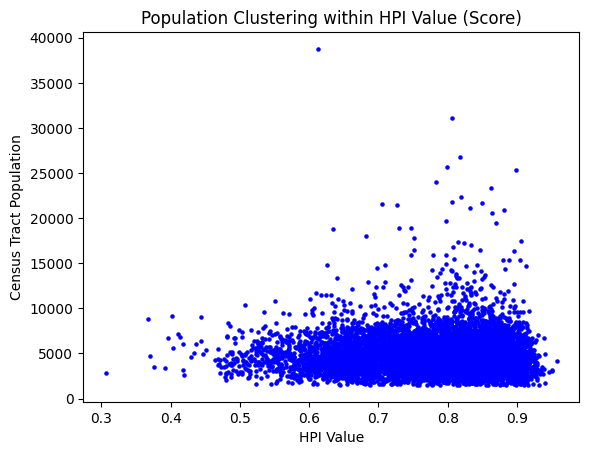

In [21]:
# Producing a Visual
#Extra credit

import matplotlib.pyplot as plt

val_by_population = plt.scatter(hpi_data['value'],hpi_data['population'], c='blue', s=5 )
val_by_population = plt.xlabel('HPI Value')
val_by_population = plt.ylabel('Census Tract Population')
val_by_population = plt.title('Population Clustering within HPI Value (Score)')

# plt.show(val_by_population)
# plt.savefig('scatter_Population Clustering.jpeg')

hpi_data.dtypes


In [7]:
import matplotlib.pyplot as plt
import plotly.express as px

xfinal_joined = final_joined[final_joined['vaccination_percentage_all'] != '99']

fig = px.scatter(xfinal_joined, x='vaccination_percentage_all', y='hpi_pctile', color='gis_hpi_quartile_sd', title='Visual for Vaccination Percentage by HPI Percentile')
fig.show()
plt.savefig('C:/Users/krist/Downloads/fig3.pdf')                        
# 


<Figure size 640x480 with 0 Axes>

In [25]:
main_trend = px.scatter(final_joined, x='vaccination_percentage_all', y='voting_pctile', color='gis_hpi_quartile_sd', title='Visual for Vaccination Percentage by Voting Percentile')
main_trend.show()

final_joined.dtypes

voting                        float64
voting_pctile                 float64
NAME                           object
GEO_ID                          int64
county                         object
pop                             int64
hpi_pctile                    float64
hpi_quartile                  float64
hpi_least_healthy_25pct        object
economic_pctile               float64
census_tract                   object
gis_hpi_quartile_sd            object
vaccination_percentage_all     object
update_date                    object
dtype: object

In [33]:
import matplotlib.pyplot as plt

# final_joined.dtypes
newfinal_joined = final_joined.convert_dtypes()

# newfinal_joined.dtypes

main_trend = px.scatter(newfinal_joined, x='vaccination_percentage_all', y='voting_pctile', color='gis_hpi_quartile_sd', title='Visual for Vaccination Percentage by Voting Percentile')
main_trend.show()

In [8]:
# Number of Census Tract by HPI Quartile

import plotly.express as px

cfinal_joined = final_joined.groupby('hpi_quartile').count().reset_index()

bar_chart = px.bar(cfinal_joined, y='census_tract', x='hpi_quartile', color='hpi_quartile', title='Number of Census Tracts by HPI Quartile')
bar_chart.show()
# bar_chart.write_image('Number of Census Tracts by HPI Quartile.pdf')


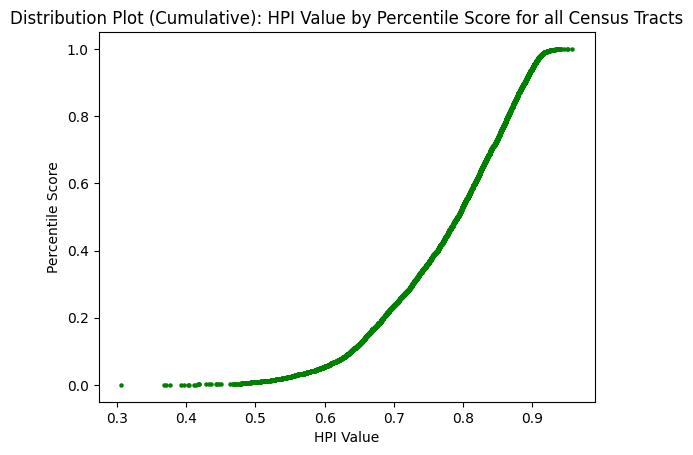

In [9]:
# Visual

val_by_percentile = plt.scatter(hpi_data['value'],hpi_data['percentile'], c='green', s=5)
val_by_percentile = plt.xlabel('HPI Value')
val_by_percentile = plt.ylabel('Percentile Score')
val_by_percentile = plt.title('Distribution Plot (Cumulative): HPI Value by Percentile Score for all Census Tracts')

# plt.show(val_by_percentile)
plt.savefig('Distribution Plot (Cumulative)- HPI Value by Percentile Score for all Census Tracts.pdf') 